In [1]:
import numpy as np
import growth_simulations as g
import os
import scipy
import time
import seaborn as sns
import weakref
import matplotlib.pyplot as plt
import scipy.stats

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
# # Setting simulation parameters
l = np.array([1.0])
td_std = np.linspace(0.0, 0.2, 3)  # 3
lambda_std = np.linspace(0.0, 0.2, num=3)  # 3
delta = np.array([1.0])
beta = np.linspace(0.025, 0.5, num=20)  # 20
r = beta/(1-beta)
alpha = np.linspace(0.0, 1.0, num=11)  # 11
num_rep = 100  # number of repeats
# # should give 99000 repeats. Run with 3000 job array.
# # should take around 4 hours.

par_vals = {'nstep': 900, 'dt': 0.01, 'v_init': 1.0, 'modeltype': 7, 'delta': delta[0], 'lambda': l[0]}
X = [len(td_std), len(lambda_std), len(beta), len(alpha), num_rep]
num_celltypes = 3  # mother, daughter, full_pop
observables = ['MD corr', 'MD corr p val', 'GR num', 'GR vol', 'td_std', 't_av', 'vb_std', 'v_av', 'linear slope']

In [5]:
def jiseon_model_2(l, beta, sigma_l, alpha):
    num = beta*(np.log(2-2*alpha+alpha/beta))**2+(1-beta)*(np.log(2-2*alpha+alpha/(1-beta)))**2
    denom = beta*np.log(2-2*alpha+alpha/beta)+(1-beta)*(np.log(2-2*alpha+alpha/(1-beta)))
    return l*(1+sigma_l**2/l**2*(-1+0.5*num/denom))

In [6]:
temp_data_1=np.load('./output_compiled.npy')
temp_data_2=np.load('./output_compiled_iteration_2.npy')

data_vals_1=np.concatenate((temp_data_1,temp_data_2),axis=4)

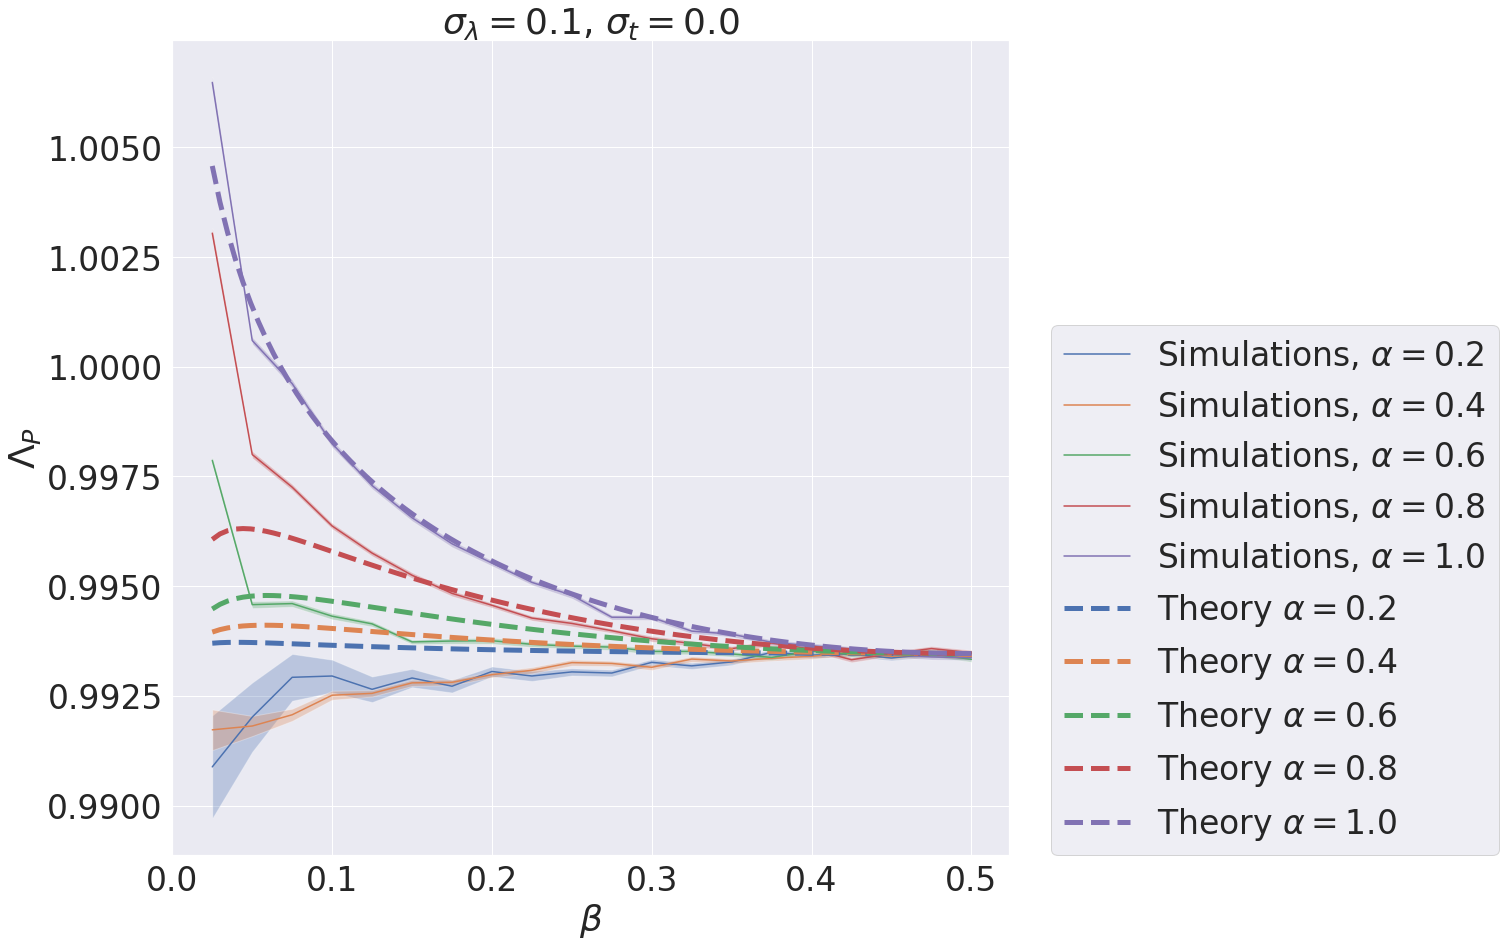

In [7]:
fig=plt.figure(figsize=[15,15])
sns.set(font_scale=3)
i0=0
i1=1
ind_beta_start=0
xv=beta[ind_beta_start:]
# sns.set(font_scale=1.5)
for ind in range(2,11,2):
    yv=np.mean(data_vals_1[i0,i1,ind_beta_start:,ind,:,2,3],axis=1)
    ystd=np.std(data_vals_1[i0,i1,ind_beta_start:,ind,:,2,3],axis=1)
    plt.plot(xv,yv,label=r'Simulations, $ \alpha={0}$'.format(alpha[ind]))
    plt.fill_between(xv,yv-ystd/np.sqrt(num_rep),yv+ystd/np.sqrt(num_rep),alpha=0.3)
xv=np.linspace(beta[ind_beta_start],0.5,100)
plt.gca().set_prop_cycle(None)
for ind in range(2,11,2):
    yv=jiseon_model_2(1.0,xv,lambda_std[i1],alpha[ind])
    plt.plot(xv,yv,label=r'Theory $\alpha={0}$'.format(alpha[ind]),linestyle='--',lw=5)
plt.xlabel(r'$\beta$')
plt.xlim(xmin=0)
plt.ylabel(r'$\Lambda_P$')
plt.title(r'$\sigma_\lambda={0}$, $\sigma_t={1}$'.format(lambda_std[i1],td_std[i0]))
plt.legend(loc=[1.05,0.0])
fig.savefig('./general_model_test.png',dpi=fig.dpi,bbox_inches='tight')

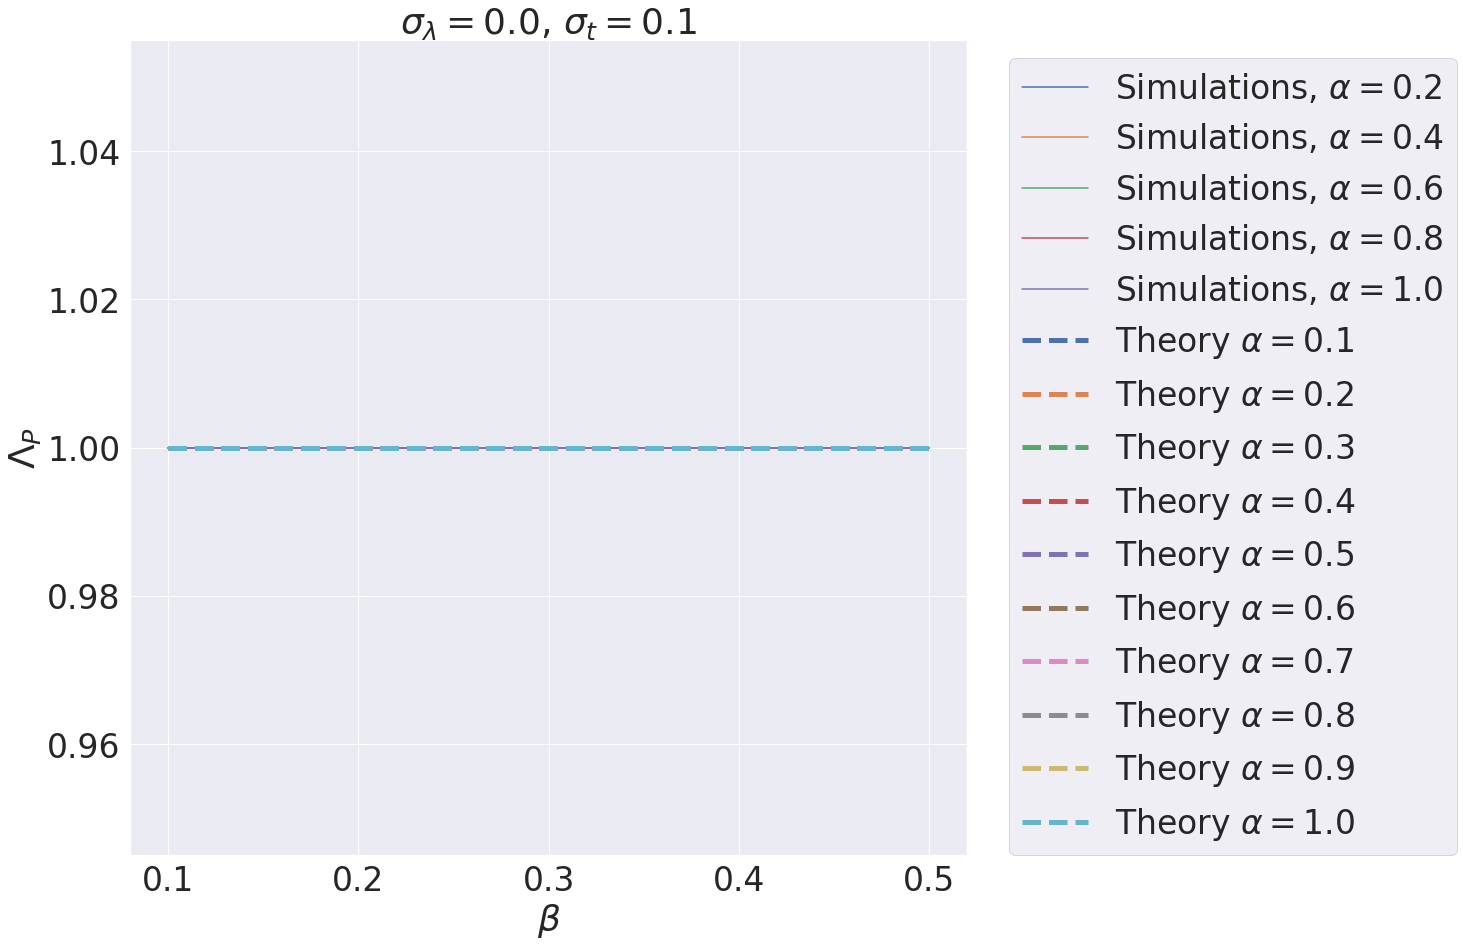

In [44]:
fig=plt.figure(figsize=[15,15])
sns.set(font_scale=3)
i0=1
i1=0
xv=beta[3:]
# sns.set(font_scale=1.5)
for ind in range(2,11,2):
    yv=np.mean(data_vals_1[i0,i1,3:,ind,:,2,3],axis=1)
    ystd=np.std(data_vals_1[i0,i1,3:,ind,:,2,3],axis=1)
    plt.plot(xv,yv,label=r'Simulations, $ \alpha={0}$'.format(alpha[ind]))
    plt.fill_between(xv,yv-ystd/np.sqrt(num_rep),yv+ystd/np.sqrt(num_rep),alpha=0.3)
xv=np.linspace(0.1,0.5,100)
plt.gca().set_prop_cycle(None)
for ind in range(2,11,2):
    yv=jiseon_model_2(1.0,xv,lambda_std[i1],alpha[ind])
    plt.plot(xv,yv,label=r'Theory $\alpha={0}$'.format(alpha[ind]),linestyle='--',lw=5)
plt.xlabel(r'$\beta$')
plt.ylabel(r'$\Lambda_P$')
plt.title(r'$\sigma_\lambda={0}$, $\sigma_t={1}$'.format(lambda_std[i1],td_std[i0]))
plt.legend(loc=[1.05,0.0])

In [48]:
def pcc_model(beta, sigma_t, gr, delta):
    # note that the growth function agrees to first order with that in the main text under the substitution delta=alpha
    temp_r=beta/(1-beta)
    num=delta/(2-delta)*((1-delta)*(np.log(temp_r)/(2*gr))**2-sigma_t**2)
    sigma_tdn=np.sqrt(2*sigma_t**2/(2-delta)+delta/(2-delta)*(np.log(temp_r)/(2*gr))**2)
    sigma_tdn1=np.sqrt((2*sigma_t**2+delta*(1-delta)**2*(np.log(temp_r)/(2*gr))**2)/(2-delta))
    denom=sigma_tdn*sigma_tdn1
    return num/denom

def pcc_model_siblings(beta, sigma_t, gr, delta):
    # note that the growth function agrees to first order with that in the main text under the substitution delta=alpha
    temp_r=beta/(1-beta)
    num=(2-delta)*sigma_t**2
    denom=2*sigma_t**2+delta*(1-delta)**2*(np.log(temp_r)/(2*gr))**2
    return 1-num/denom

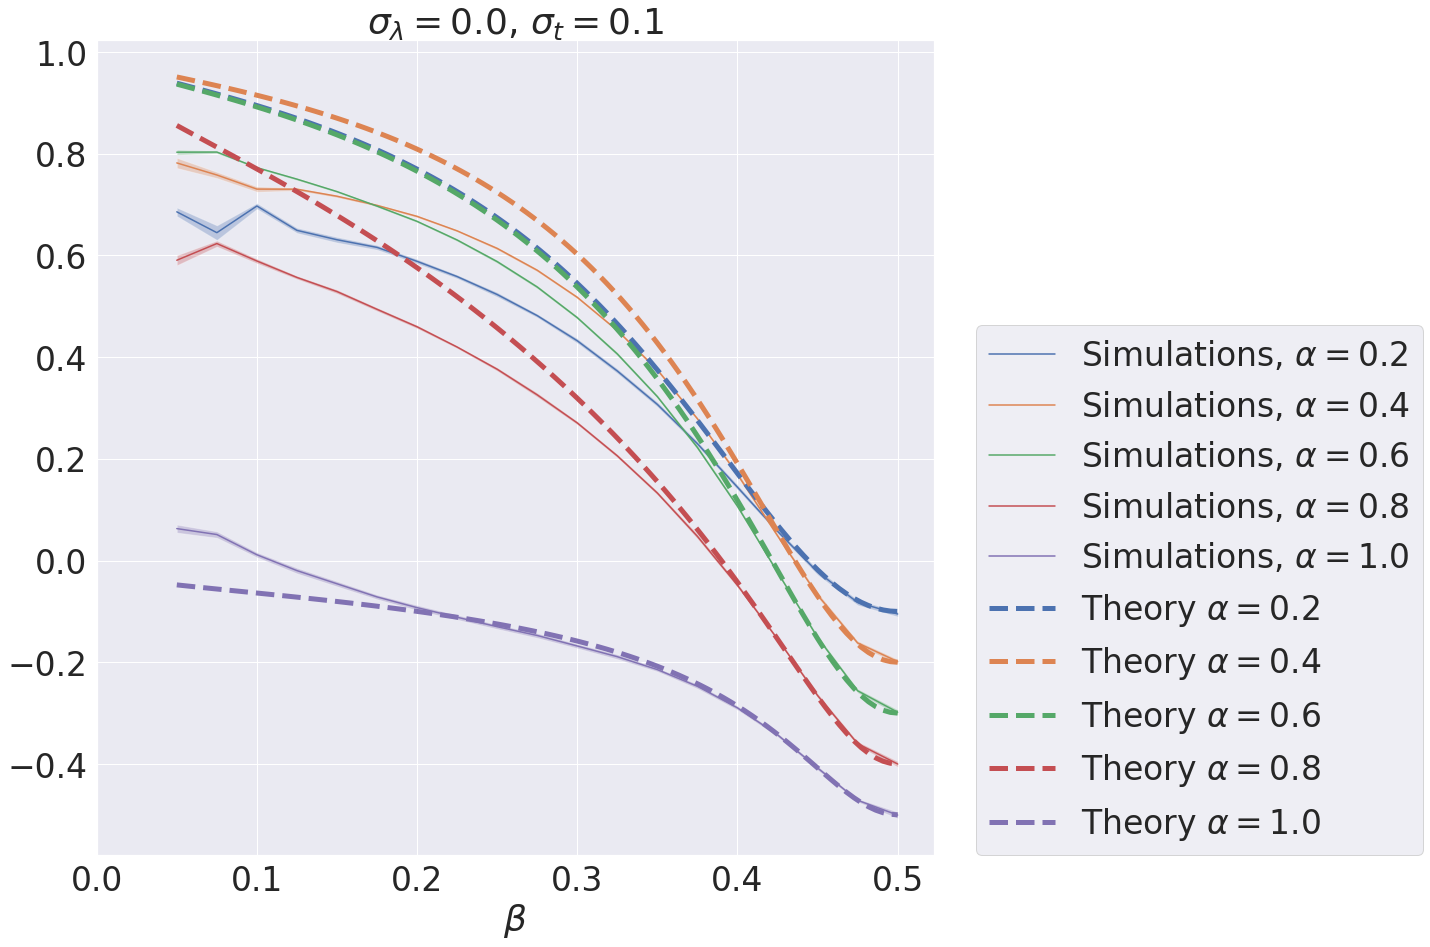

In [61]:
fig=plt.figure(figsize=[15,15])
sns.set(font_scale=3)
i0=1
i1=0
ind_beta_start=1
xv=beta[ind_beta_start:]
# sns.set(font_scale=1.5)
for ind in range(2,11,2):
    yv=np.mean(data_vals_1[i0,i1,ind_beta_start:,ind,:,0,0],axis=1)
    ystd=np.std(data_vals_1[i0,i1,ind_beta_start:,ind,:,0,0],axis=1)
    plt.plot(xv,yv,label=r'Simulations, $ \alpha={0}$'.format(alpha[ind]))
    plt.fill_between(xv,yv-ystd,yv+ystd,alpha=0.3)
xv=np.linspace(beta[ind_beta_start],0.5,100)
plt.gca().set_prop_cycle(None)
for ind in range(2,11,2):
    yv=pcc_model(xv,td_std[i0],1.0,alpha[ind])
    plt.plot(xv,yv,label=r'Theory $\alpha={0}$'.format(alpha[ind]),linestyle='--',lw=5)
plt.xlabel(r'$\beta$')
plt.xlim(xmin=0)
# plt.ylabel(r'$\Lambda_P$')
plt.title(r'$\sigma_\lambda={0}$, $\sigma_t={1}$'.format(lambda_std[i1],td_std[i0]))
plt.legend(loc=[1.05,0.0])
# fig.savefig('./general_model_test.png',dpi=fig.dpi,bbox_inches='tight')

In [63]:
data_vals_1.shape

(3, 3, 20, 11, 50, 3, 9)

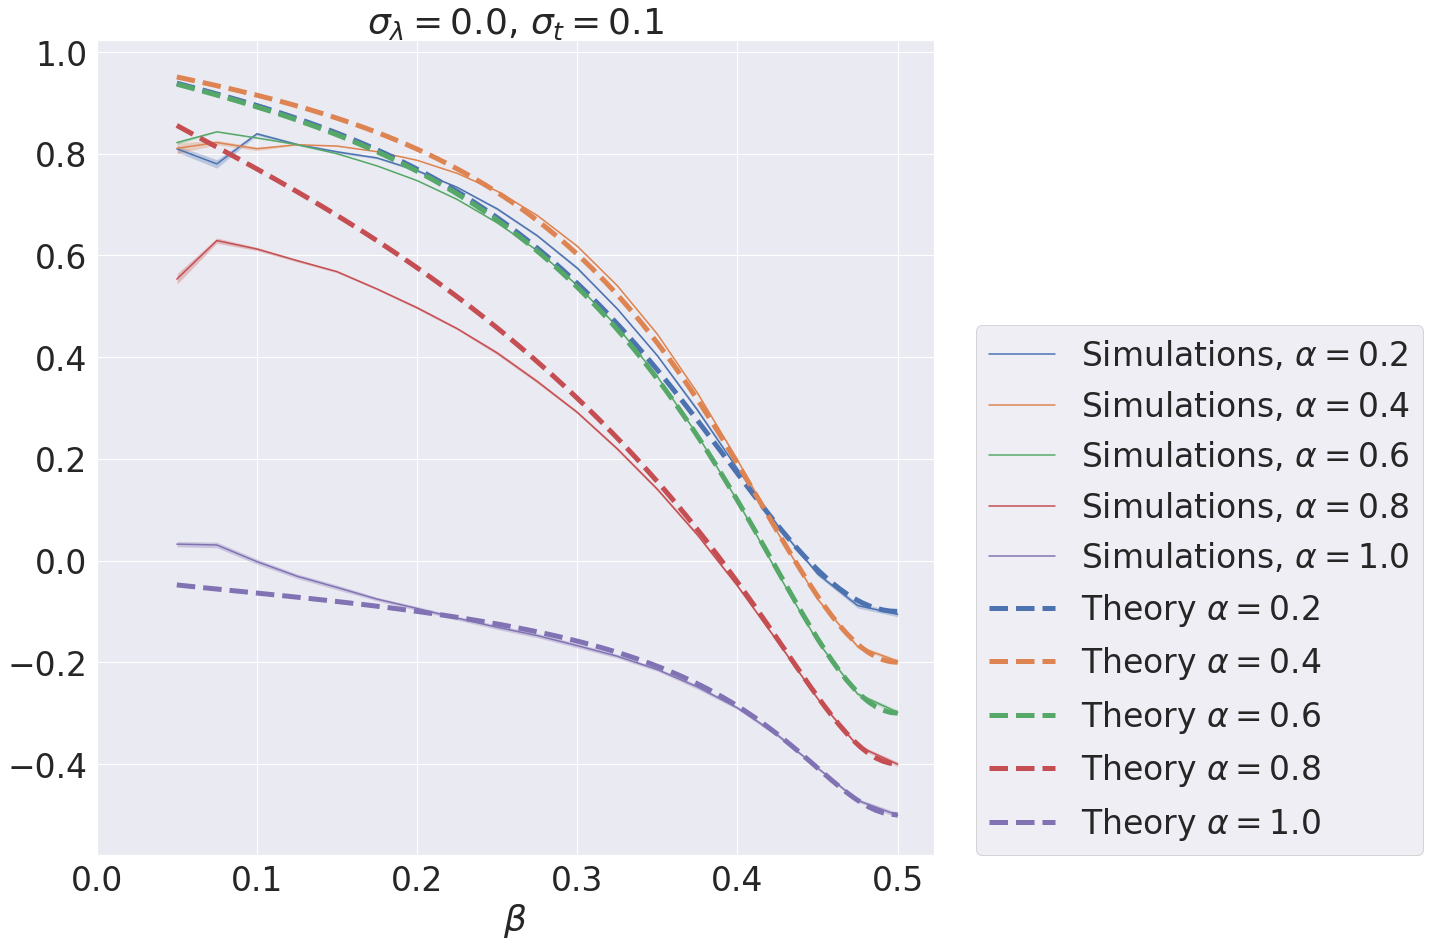

In [59]:
fig=plt.figure(figsize=[15,15])
sns.set(font_scale=3)
i0=1
i1=0
ind_beta_start=1
xv=beta[ind_beta_start:]
# sns.set(font_scale=1.5)
for ind in range(2,11,2):
    yv=np.mean(data_vals_1[i0,i1,ind_beta_start:,ind,:,1,0],axis=1)
    ystd=np.std(data_vals_1[i0,i1,ind_beta_start:,ind,:,1,0],axis=1)
    plt.plot(xv,yv,label=r'Simulations, $ \alpha={0}$'.format(alpha[ind]))
    plt.fill_between(xv,yv-ystd,yv+ystd,alpha=0.3)
xv=np.linspace(beta[ind_beta_start],0.5,100)
plt.gca().set_prop_cycle(None)
for ind in range(2,11,2):
    yv=pcc_model(xv,td_std[i0],1.0,alpha[ind])
    plt.plot(xv,yv,label=r'Theory $\alpha={0}$'.format(alpha[ind]),linestyle='--',lw=5)
plt.xlabel(r'$\beta$')
plt.xlim(xmin=0)
# plt.ylabel(r'$\Lambda_P$')
plt.title(r'$\sigma_\lambda={0}$, $\sigma_t={1}$'.format(lambda_std[i1],td_std[i0]))
plt.legend(loc=[1.05,0.0])
# fig.savefig('./general_model_test.png',dpi=fig.dpi,bbox_inches='tight')

Although this clearly shows deviations from our model predictions for highly asymmetric division. The reason for this is simple: As division asymmetry grows more pronounced, mother cells grow larger and larger. The amount of time required for them to grow also decreases, until the growth period is small enough for a significant fraction of mother cells to have "negative growth durations" due to noise. In a lineage process where growth duration doesn't matter (as is theoretically modeled here) this is fine, but for a population growth simulation, these cells are anomalous and must be altered somehow. This demonstrates the pathological behavior of extreme division asymmetry.

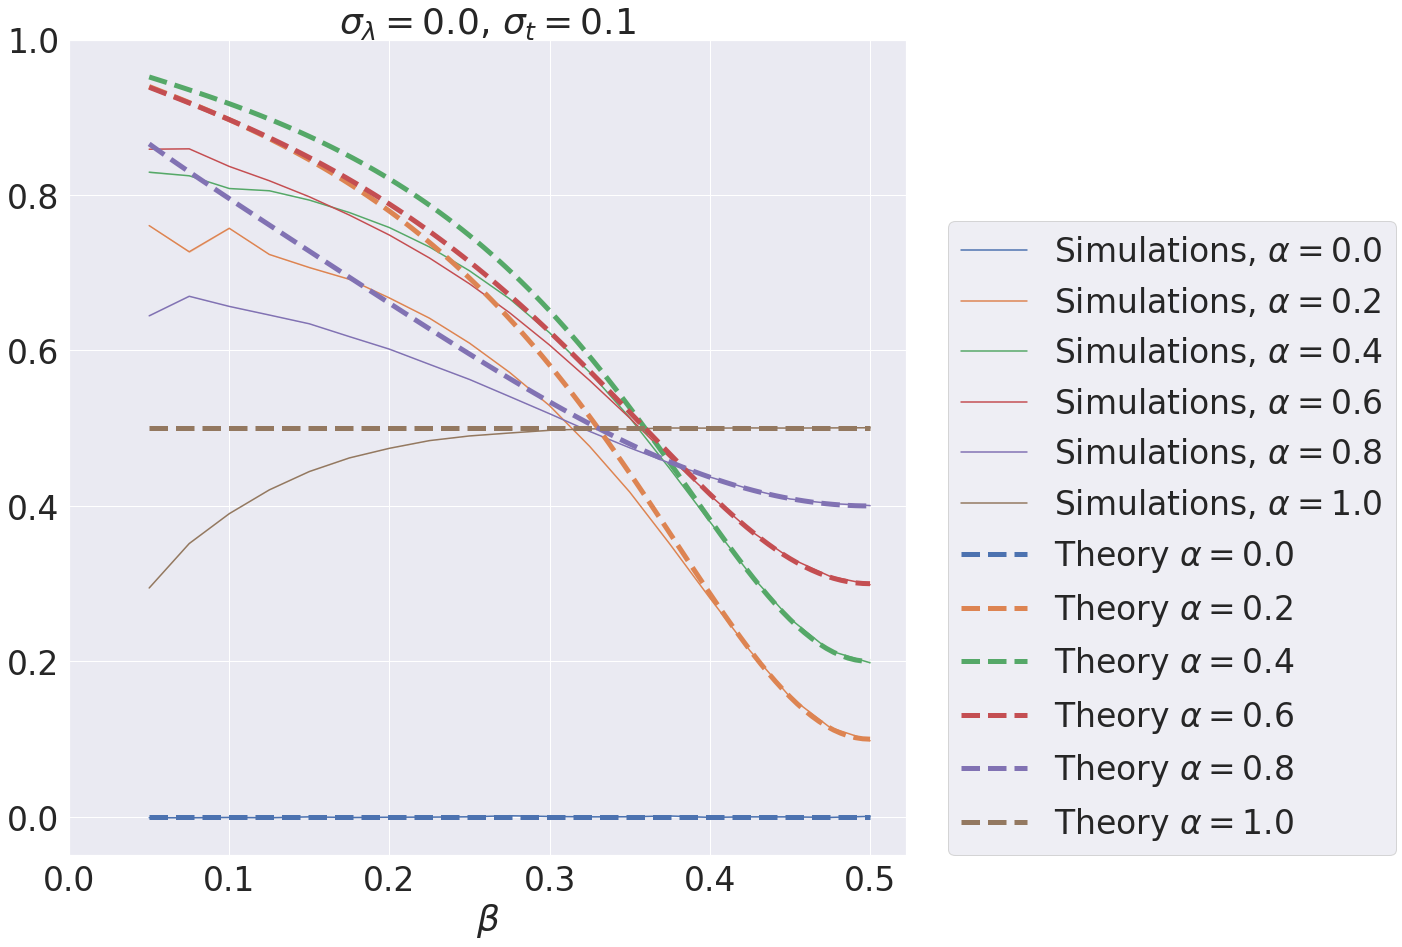

In [62]:
fig=plt.figure(figsize=[15,15])
sns.set(font_scale=3)
i0=1
i1=0
ind_beta_start=1
xv=beta[ind_beta_start:]
# sns.set(font_scale=1.5)
for ind in range(0,11,2):
    yv=np.mean(data_vals_1[i0,i1,ind_beta_start:,ind,:,2,0],axis=1)
    ystd=np.std(data_vals_1[i0,i1,ind_beta_start:,ind,:,2,0],axis=1)
    plt.plot(xv,yv,label=r'Simulations, $ \alpha={0}$'.format(alpha[ind]))
    plt.fill_between(xv,yv-ystd/np.sqrt(num_rep),yv+ystd/np.sqrt(num_rep),alpha=0.3)
xv=np.linspace(beta[ind_beta_start],0.5,100)
plt.gca().set_prop_cycle(None)
for ind in range(0,11,2):
    yv=pcc_model_siblings(xv,td_std[i0],1.0,alpha[ind])
    plt.plot(xv,yv,label=r'Theory $\alpha={0}$'.format(alpha[ind]),linestyle='--',lw=5)
plt.xlabel(r'$\beta$')
plt.xlim(xmin=0)
# plt.ylabel(r'$\Lambda_P$')
plt.title(r'$\sigma_\lambda={0}$, $\sigma_t={1}$'.format(lambda_std[i1],td_std[i0]))
plt.legend(loc=[1.05,0.0])
# fig.savefig('./general_model_test.png',dpi=fig.dpi,bbox_inches='tight')